In [1]:
import pandas as pd

In [1]:
import pandas as pd
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
from gutenberg.query import get_etexts
from gutenberg.query import get_metadata

wizard_of_oz_text = strip_headers(load_etext(55, mirror='http://www.mirrorservice.org/sites/ftp.ibiblio.org/pub/docs/books/gutenberg/')).strip()

king_arthur_text = strip_headers(load_etext(12753,mirror='http://www.mirrorservice.org/sites/ftp.ibiblio.org/pub/docs/books/gutenberg/')).strip()

romeo_and_juliet_text = strip_headers(load_etext(1513,mirror='http://www.mirrorservice.org/sites/ftp.ibiblio.org/pub/docs/books/gutenberg/')).strip()

great_expectations_text = strip_headers(load_etext(1400,mirror='http://www.mirrorservice.org/sites/ftp.ibiblio.org/pub/docs/books/gutenberg/')).strip()
#get 4 df that we'll be combined
oz_lines = wizard_of_oz_text.splitlines()
oz_df = pd.DataFrame({
     "content": oz_lines,
     "line": list(range(len(oz_lines)))
 })

king_arthur_lines = king_arthur_text.splitlines()
king_arthur_df = pd.DataFrame({
     "content": king_arthur_lines,
     "line": list(range(len(king_arthur_lines)))
})

romeo_and_juliet_lines = romeo_and_juliet_text.splitlines()
romeo_and_juliet_df = pd.DataFrame({
     "content": romeo_and_juliet_lines,
     "line": list(range(len(romeo_and_juliet_lines)))
})

great_expectations_lines = great_expectations_text.splitlines()
great_expectations_df = pd.DataFrame({
     "content": great_expectations_lines,
     "line": list(range(len(great_expectations_lines)))
})
#Add the book title information as a new column and create the combined books df
oz_df = oz_df.assign(book='Wizard of oz')

king_arthur_df = king_arthur_df.assign(book='Legends of king Arthur')

romeo_and_juliet_df = romeo_and_juliet_df.assign(book='Romeo and Juliet')

great_expectations_df = great_expectations_df.assign(book='Great expectations')

my_books_list = [oz_df, king_arthur_df, romeo_and_juliet_df, great_expectations_df]
my_books_df = pd.concat(my_books_list)
my_books_df



,content,line,book
0,[Illustration],0,Wizard of oz
1,,1,Wizard of oz
2,,2,Wizard of oz
3,,3,Wizard of oz
4,,4,Wizard of oz
...,...,...,...
20392,"I took her hand in mine, and we went out of th...",20392,Great expectations
20393,the morning mists had risen long ago when I fi...,20393,Great expectations
20394,"the evening mists were rising now, and in all ...",20394,Great expectations
20395,"tranquil light they showed to me, I saw no sha...",20395,Great expectations


In [2]:
from tidytext import unnest_tokens
import nltk
nltk.download('punkt')
my_books_df = (unnest_tokens(my_books_df, "word", "content"))
my_books_df = my_books_df.reset_index()
my_books_df = my_books_df.drop(columns=['index'])
my_books_df

[nltk_data] Downloading package punkt to /home/cristinica/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,line,book,word
0,0,Wizard of oz,illustration
1,1,Wizard of oz,NaN
2,2,Wizard of oz,NaN
3,3,Wizard of oz,NaN
4,4,Wizard of oz,NaN
...,...,...,...
369438,20395,Great expectations,of
369439,20395,Great expectations,another
369440,20395,Great expectations,parting
369441,20396,Great expectations,from


In [3]:
from siuba import *
from plotnine import *
book_words = count(my_books_df, _.book, _.word, sort=True)
book_words

total_words = (book_words
     >> group_by(_.book)
     >> summarize(total = _.n.sum())
)
 
total_words


,book,total
0,Great expectations,197463
1,Legends of king Arthur,93666
2,Romeo and Juliet,27616
3,Wizard of oz,42332


In [4]:
#We'll add this information to our previous dataframe by using a left join
histogram_df = left_join(book_words, total_words)
histogram_df
#cuvantul, cartea de care apartine, numarul de aparitii(din cartea resp) si totalul de cuvinte(din cartea resp) => term frequency
#tf = nr de aparitii al unui cuv/totalul de cuvinte

,book,word,n,total
0,Great expectations,the,8121,197463
1,Great expectations,and,6957,197463
2,Great expectations,i,6595,197463
3,Legends of king Arthur,and,5606,93666
4,Great expectations,to,5054,197463
...,...,...,...,...
24023,Legends of king Arthur,corner,1,93666
24024,Great expectations,enjoyment—i,1,197463
24025,Legends of king Arthur,cornwallthe,1,93666
24026,Legends of king Arthur,cost,1,93666


/home/cristinica/anaconda3/envs/dm/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 645 rows containing non-finite values.
/home/cristinica/anaconda3/envs/dm/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_histogram : Removed 4 rows containing missing values.


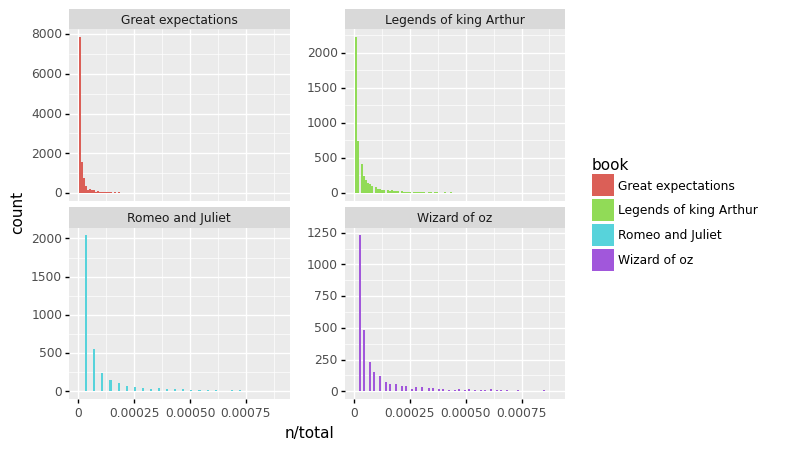

<ggplot: (8781097090813)>

In [5]:
ggplot(histogram_df) + aes(x="n/total", fill='book') + geom_histogram(bins=100) + xlim(None, 0.0009) + facet_wrap('~book', ncol = 2, scales = "free_y") + theme(subplots_adjust={'wspace': 0.25})
#pe axa x- n/total ->tf (frecventa)
#pe axa y- nr de aparitii
#pt frecventa foarte mica => cuv foarte rare
#avem foarte multe cuvinte rare
#cu cat are mai multe aparitii, nr de cuv sunt tot mai putine

In [6]:
histogram_df = histogram_df.assign(rank=book_words.groupby("book").cumcount() + 1)

histogram_df = histogram_df.assign(term_frequency = histogram_df['n'] /histogram_df['total'])
 
histogram_df

,book,word,n,total,rank,term_frequency
0,Great expectations,the,8121,197463,1,0.041127
1,Great expectations,and,6957,197463,2,0.035232
2,Great expectations,i,6595,197463,3,0.033399
3,Legends of king Arthur,and,5606,93666,1,0.059851
4,Great expectations,to,5054,197463,4,0.025595
...,...,...,...,...,...,...
24023,Legends of king Arthur,corner,1,93666,5205,0.000011
24024,Great expectations,enjoyment—i,1,197463,12187,0.000005
24025,Legends of king Arthur,cornwallthe,1,93666,5206,0.000011
24026,Legends of king Arthur,cost,1,93666,5207,0.000011


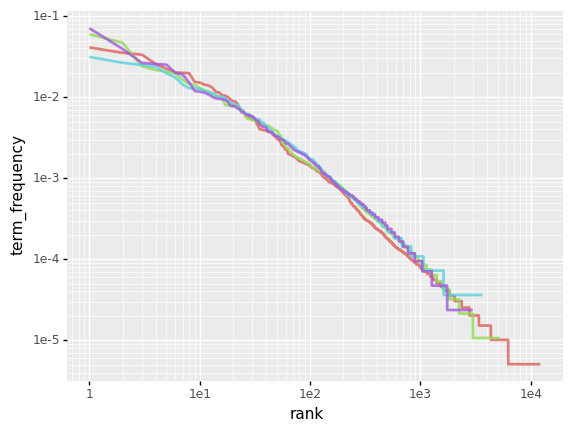

<ggplot: (8781094788527)>

In [7]:
ggplot(histogram_df) + aes(x="rank", y='term_frequency', color='book') + geom_line(size = 1.1, alpha = 0.8, show_legend = False) + scale_x_log10() + scale_y_log10()

 

In [8]:
from tidytext import *

book_tf_idf = bind_tf_idf(book_words, 'word', 'book', 'n')
book_tf_idf
 

,book,word,n,tf,idf,tf_idf
0,Great expectations,the,8121,0.041127,0.000000,0.000000
1,Great expectations,and,6957,0.035232,0.000000,0.000000
2,Great expectations,i,6595,0.033399,0.000000,0.000000
3,Legends of king Arthur,and,5606,0.059851,0.000000,0.000000
4,Great expectations,to,5054,0.025595,0.000000,0.000000
...,...,...,...,...,...,...
24023,Legends of king Arthur,corner,1,0.000011,0.287682,0.000003
24024,Great expectations,enjoyment—i,1,0.000005,1.386294,0.000007
24025,Legends of king Arthur,cornwallthe,1,0.000011,1.386294,0.000015
24026,Legends of king Arthur,cost,1,0.000011,0.000000,0.000000


In [9]:
book_tf_idf_cut = book_tf_idf

In [10]:
arrange(book_tf_idf_cut, -_.tf_idf)

,book,word,n,tf,idf,tf_idf
44,Wizard of oz,“,1084,0.025607,0.693147,0.017749
46,Wizard of oz,”,1065,0.025158,0.693147,0.017438
167,Romeo and Juliet,romeo,315,0.011406,1.386294,0.015813
8,Great expectations,“,3945,0.019978,0.693147,0.013848
9,Great expectations,”,3908,0.019791,0.693147,0.013718
...,...,...,...,...,...,...
23969,Legends of king Arthur,comes,1,0.000011,0.000000,0.000000
23998,Legends of king Arthur,cover,1,0.000011,0.000000,0.000000
24011,Legends of king Arthur,contents,1,0.000011,0.000000,0.000000
24013,Legends of king Arthur,continue,1,0.000011,0.000000,0.000000


In [38]:
tf_idf_df = ungroup(group_by(arrange(book_tf_idf_cut, -_.tf_idf),'book').head(10))
tf_idf_df
 #ne luam primele 10 cuvinte din fiecare carte dupa tf_idf din fiecare carte

,book,word,n,tf,idf,tf_idf
167,Romeo and Juliet,romeo,315,0.011406,1.386294,0.015813
141,Wizard of oz,dorothy,369,0.008717,1.386294,0.012084
268,Romeo and Juliet,juliet,190,0.006880,1.386294,0.009538
55,Romeo and Juliet,’,867,0.031395,0.287682,0.009032
317,Romeo and Juliet,capulet,163,0.005902,1.386294,0.008182
117,Legends of king Arthur,knights,426,0.004548,1.386294,0.006305
274,Wizard of oz,woodman,183,0.004323,1.386294,0.005993
137,Legends of king Arthur,lancelot,378,0.004036,1.386294,0.005595
316,Wizard of oz,oz,163,0.003851,1.386294,0.005338
473,Romeo and Juliet,friar,105,0.003802,1.386294,0.005271


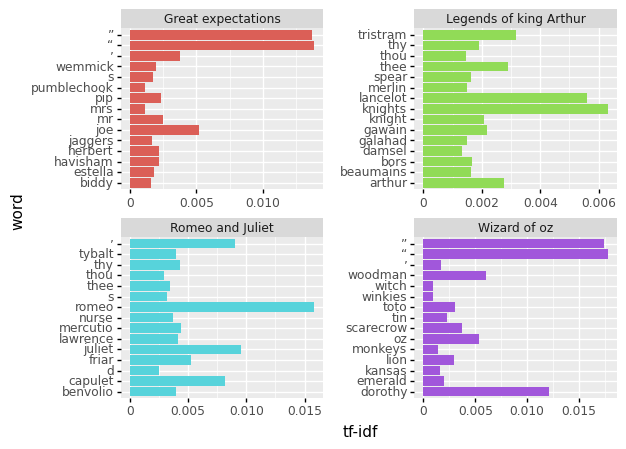

<ggplot: (8761074738794)>

In [33]:
from siuba.dply.forcats import fct_lump, fct_reorder

ggplot(tf_idf_df) + aes(x="word", y='tf_idf', fill='book') + coord_flip() + geom_col(show_legend = False) + facet_wrap('~book', ncol = 2, scales = "free") + labs(y = "tf-idf", x = 'word') + theme(subplots_adjust={'wspace': 0.15}) + theme(subplots_adjust={'wspace': 0.45, 'hspace': 0.3})


In [34]:
#If we want to view the words in decreasing tf_idf order, let’s do a reordering before the plot
ordered_tf_idf_df = arrange(tf_idf_df, _.book, -_.tf_idf)
ordered_tf_idf_df
#le grupam prima data dupa carte
#si in cadrul fiecarei carti, ordonam desc dupa tf_idf

,book,word,n,tf,idf,tf_idf
8,Great expectations,“,3945,0.019978,0.693147,0.013848
9,Great expectations,”,3908,0.019791,0.693147,0.013718
67,Great expectations,joe,738,0.003737,1.386294,0.005181
15,Great expectations,’,2596,0.013147,0.287682,0.003782
73,Great expectations,mr,710,0.003596,0.693147,0.002492
155,Great expectations,pip,334,0.001691,1.386294,0.002345
166,Great expectations,havisham,315,0.001595,1.386294,0.002211
170,Great expectations,herbert,312,0.001580,1.386294,0.002190
191,Great expectations,wemmick,282,0.001428,1.386294,0.001980
205,Great expectations,estella,262,0.001327,1.386294,0.001839


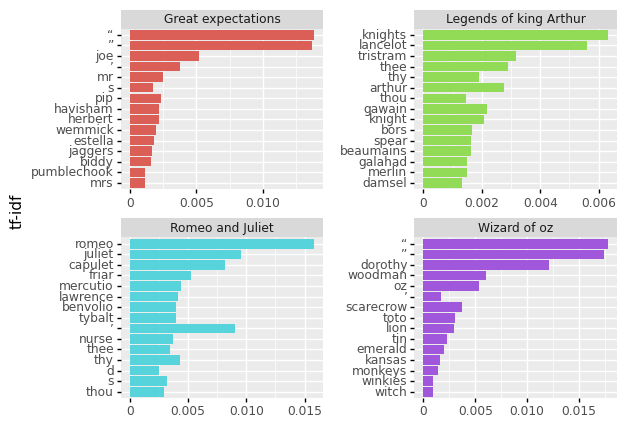

<ggplot: (8761074589257)>

In [35]:
ggplot(ordered_tf_idf_df) + aes(x=fct_reorder(ordered_tf_idf_df['word'], x=ordered_tf_idf_df['tf_idf']), y='tf_idf', fill='book') + coord_flip() + geom_col(show_legend = False) + facet_wrap('~book', ncol = 2, scales = "free") + labs(x = "tf-idf", y = None) + theme(subplots_adjust={'wspace': 0.15}) + theme(subplots_adjust={'wspace': 0.45, 'hspace': 0.3}) + scale_x_discrete()
#ordonam cuv dupa tf_idf desc

In [36]:
#curatam stopwords
mystopwords = ['”', '“', 't','dr']
book_tf_idf_cut = filter(book_tf_idf_cut, ~_.word.isin(mystopwords))
book_tf_idf_cut

,book,word,n,tf,idf,tf_idf
0,Great expectations,the,8121,0.041127,0.000000,0.000000
1,Great expectations,and,6957,0.035232,0.000000,0.000000
2,Great expectations,i,6595,0.033399,0.000000,0.000000
3,Legends of king Arthur,and,5606,0.059851,0.000000,0.000000
4,Great expectations,to,5054,0.025595,0.000000,0.000000
...,...,...,...,...,...,...
24023,Legends of king Arthur,corner,1,0.000011,0.287682,0.000003
24024,Great expectations,enjoyment—i,1,0.000005,1.386294,0.000007
24025,Legends of king Arthur,cornwallthe,1,0.000011,1.386294,0.000015
24026,Legends of king Arthur,cost,1,0.000011,0.000000,0.000000


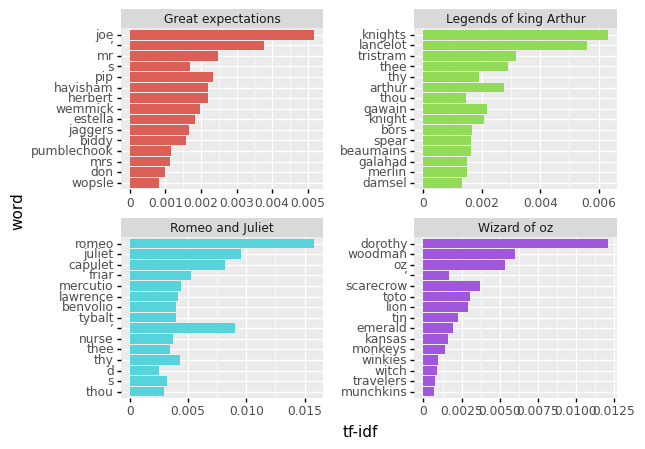

<ggplot: (8761072829943)>

In [37]:
p_tf_idf_df = ungroup(group_by(arrange(book_tf_idf_cut, -_.tf_idf),'book').head(15))
p_tf_idf_df
ordered_p_tf = arrange(p_tf_idf_df, _.book, -_.tf_idf)
ordered_p_tf
 
ggplot(arrange(p_tf_idf_df, _.book, -_.tf_idf)) + aes(x=fct_reorder(ordered_p_tf['word'], x=ordered_p_tf['tf_idf']), y='tf_idf', fill='book') + coord_flip() + geom_col(show_legend = False) + facet_wrap('~book', ncol = 2, scales = "free") + labs(y = "tf-idf", x = 'word') + theme(subplots_adjust={'wspace': 0.15}) + theme(subplots_adjust={'wspace': 0.45, 'hspace': 0.3}) + scale_x_discrete()

